In [2]:
#data Augmenter
import os
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm

# Paths
input_root = r'D:\Cellula Internship\Project_1_Teeth_Class\Pre_augment\Teeth_Dataset\Training'  # Your dataset directory
output_root = r'D:\Cellula Internship\Project_1_Teeth_Class\After_augment'  # Where to save augmented images

# Number of augmentations per image
n_augmentations = 3

# Define augmentation pipeline
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
])

# Load dataset
dataset = ImageFolder(root=input_root)

# Loop over dataset
for img_path, class_idx in tqdm(dataset.imgs, desc="Augmenting"):
    class_name = dataset.classes[class_idx]
    class_input_dir = os.path.join(input_root, class_name)
    class_output_dir = os.path.join(output_root, class_name)

    # Create output class dir if it doesn't exist
    os.makedirs(class_output_dir, exist_ok=True)

    # Open original image
    img = Image.open(img_path).convert('RGB')

    # Save augmentations
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    for i in range(n_augmentations):
        augmented_img = augmentation(img)
        save_path = os.path.join(class_output_dir, f"{base_name}_aug{i}.jpg")
        augmented_img.save(save_path)

print("✅ Augmentation complete.")


Augmenting: 100%|██████████| 3087/3087 [00:39<00:00, 78.51it/s]

✅ Augmentation complete.


In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2
from sklearn.metrics import f1_score
from tqdm import tqdm

# Paths
train_dir = r'D:\Cellula Internship\Project_1_Teeth_Class\New_dataSet\Training'
val_dir = r'Project_1_Teeth_Class/New_dataSet/Validation'

# Config
num_classes = 7  # CHANGE THIS
batch_size = 32
img_size = 224
num_epochs = 20
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transforms with normalization
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],   # ImageNet mean
                         [0.229, 0.224, 0.225])   # ImageNet std
])

# Datasets and loaders
train_dataset = ImageFolder(train_dir, transform=transform)
val_dataset = ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# MobileNetV2 from scratch
model = mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total, correct = 0, 0
    all_preds, all_labels = [], []

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_acc = 100 * correct / total
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Train Loss: {running_loss:.4f} | Accuracy: {train_acc:.2f}% | F1 Score: {train_f1:.4f}")

    # Validation
    model.eval()
    correct_val, total_val = 0, 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (preds == labels).sum().item()
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = 100 * correct_val / total_val
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    print(f"Validation Accuracy: {val_acc:.2f}% | F1 Score: {val_f1:.4f}\n")

# Save model
torch.save(model.state_dict(), "mobilenetv2_trained_with_f1.pth")


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/20: 100%|██████████| 386/386 [00:41<00:00,  9.21it/s]


Train Loss: 643.1127 | Accuracy: 34.04% | F1 Score: 0.3288
Validation Accuracy: 42.02% | F1 Score: 0.3851



Epoch 2/20: 100%|██████████| 386/386 [00:38<00:00, 10.02it/s]


Train Loss: 491.4875 | Accuracy: 52.26% | F1 Score: 0.5174
Validation Accuracy: 65.95% | F1 Score: 0.6538



Epoch 3/20: 100%|██████████| 386/386 [00:39<00:00,  9.69it/s]


Train Loss: 350.7873 | Accuracy: 66.93% | F1 Score: 0.6673
Validation Accuracy: 71.11% | F1 Score: 0.7012



Epoch 4/20: 100%|██████████| 386/386 [00:38<00:00, 10.03it/s]


Train Loss: 253.3833 | Accuracy: 76.48% | F1 Score: 0.7645
Validation Accuracy: 81.42% | F1 Score: 0.8144



Epoch 5/20: 100%|██████████| 386/386 [00:38<00:00,  9.95it/s]


Train Loss: 167.7345 | Accuracy: 84.26% | F1 Score: 0.8423
Validation Accuracy: 85.60% | F1 Score: 0.8550



Epoch 6/20: 100%|██████████| 386/386 [00:39<00:00,  9.80it/s]


Train Loss: 117.7626 | Accuracy: 89.47% | F1 Score: 0.8956
Validation Accuracy: 87.84% | F1 Score: 0.8799



Epoch 7/20: 100%|██████████| 386/386 [00:37<00:00, 10.20it/s]


Train Loss: 89.8691 | Accuracy: 92.02% | F1 Score: 0.9206
Validation Accuracy: 90.27% | F1 Score: 0.9049



Epoch 8/20: 100%|██████████| 386/386 [00:40<00:00,  9.44it/s]


Train Loss: 70.0528 | Accuracy: 93.67% | F1 Score: 0.9366
Validation Accuracy: 90.95% | F1 Score: 0.9100



Epoch 9/20: 100%|██████████| 386/386 [00:42<00:00,  9.03it/s]


Train Loss: 68.9585 | Accuracy: 93.97% | F1 Score: 0.9396
Validation Accuracy: 89.69% | F1 Score: 0.8995



Epoch 10/20: 100%|██████████| 386/386 [00:40<00:00,  9.55it/s]


Train Loss: 53.9393 | Accuracy: 95.12% | F1 Score: 0.9513
Validation Accuracy: 91.34% | F1 Score: 0.9129



Epoch 11/20: 100%|██████████| 386/386 [00:40<00:00,  9.43it/s]


Train Loss: 49.5085 | Accuracy: 95.79% | F1 Score: 0.9581
Validation Accuracy: 93.97% | F1 Score: 0.9386



Epoch 12/20: 100%|██████████| 386/386 [00:39<00:00,  9.78it/s]


Train Loss: 41.1546 | Accuracy: 96.44% | F1 Score: 0.9646
Validation Accuracy: 91.93% | F1 Score: 0.9215



Epoch 13/20: 100%|██████████| 386/386 [00:39<00:00,  9.82it/s]


Train Loss: 41.2194 | Accuracy: 96.39% | F1 Score: 0.9642
Validation Accuracy: 93.77% | F1 Score: 0.9385



Epoch 14/20: 100%|██████████| 386/386 [00:39<00:00,  9.67it/s]


Train Loss: 38.0623 | Accuracy: 96.63% | F1 Score: 0.9661
Validation Accuracy: 95.53% | F1 Score: 0.9559



Epoch 15/20: 100%|██████████| 386/386 [00:40<00:00,  9.50it/s]


Train Loss: 35.9604 | Accuracy: 96.79% | F1 Score: 0.9681
Validation Accuracy: 94.07% | F1 Score: 0.9384



Epoch 16/20: 100%|██████████| 386/386 [00:39<00:00,  9.65it/s]


Train Loss: 38.9614 | Accuracy: 96.49% | F1 Score: 0.9649
Validation Accuracy: 95.82% | F1 Score: 0.9567



Epoch 17/20: 100%|██████████| 386/386 [00:39<00:00,  9.77it/s]


Train Loss: 25.5013 | Accuracy: 97.72% | F1 Score: 0.9772
Validation Accuracy: 97.76% | F1 Score: 0.9778



Epoch 18/20: 100%|██████████| 386/386 [00:38<00:00,  9.92it/s]


Train Loss: 34.7655 | Accuracy: 96.91% | F1 Score: 0.9692
Validation Accuracy: 95.53% | F1 Score: 0.9545



Epoch 19/20: 100%|██████████| 386/386 [00:40<00:00,  9.54it/s]


Train Loss: 26.4726 | Accuracy: 97.70% | F1 Score: 0.9769
Validation Accuracy: 98.05% | F1 Score: 0.9792



Epoch 20/20: 100%|██████████| 386/386 [00:40<00:00,  9.62it/s]


Train Loss: 20.8905 | Accuracy: 98.18% | F1 Score: 0.9816
Validation Accuracy: 95.33% | F1 Score: 0.9546



c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Testing: 100%|██████████| 33/33 [00:09<00:00,  3.44it/s]



✅ Test Accuracy: 94.26%
✅ Test F1 Score (macro): 0.9418

Classification Report:
               precision    recall  f1-score   support

         CaS       0.97      0.89      0.93       160
         CoS       0.96      1.00      0.98       149
         Gum       0.99      0.92      0.95       120
          MC       0.87      0.98      0.92       180
          OC       0.96      0.84      0.90       108
         OLP       0.94      0.96      0.95       180
          OT       0.96      0.97      0.97       131

    accuracy                           0.94      1028
   macro avg       0.95      0.94      0.94      1028
weighted avg       0.95      0.94      0.94      1028



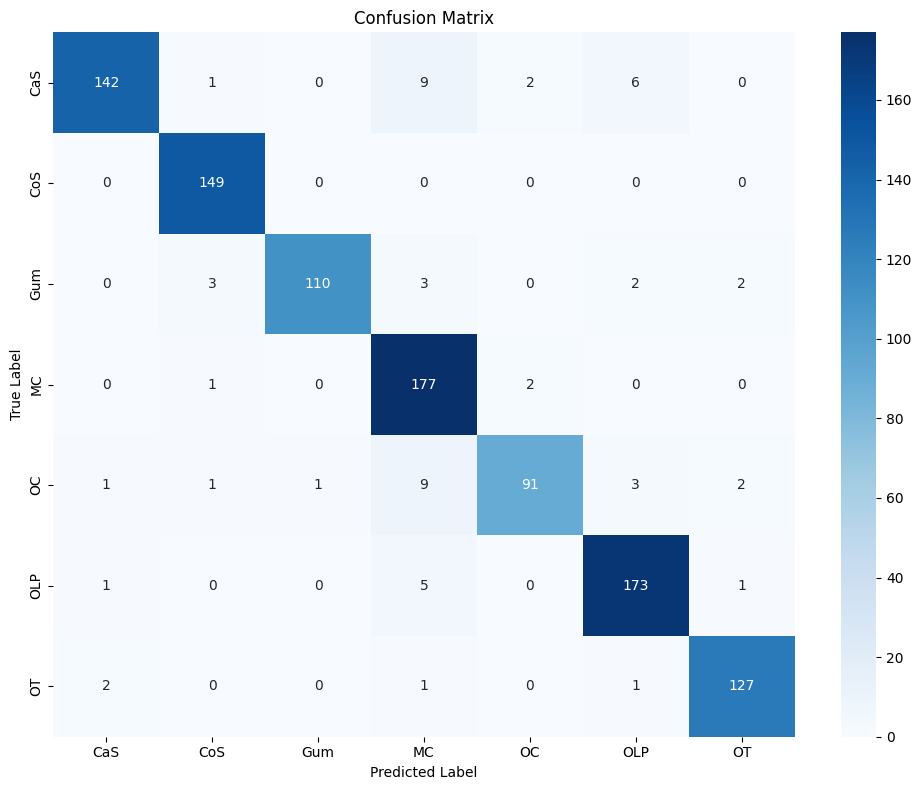

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIG ===
test_dir = r'D:\Cellula Internship\Project_1_Teeth_Class\Pre_augment\Teeth_Dataset\Testing'  # 🔁 Replace with your actual test folder path
model_path = r'D:\Cellula Internship\mobilenetv2_trained_with_f1.pth'
num_classes = 7  # 🔁 Set your actual number of classes
batch_size = 32
img_size = 224
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === DATA TRANSFORMS ===
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],   # ImageNet mean
                         [0.229, 0.224, 0.225])   # ImageNet std
])

# === LOAD DATA ===
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# === LOAD MODEL ===
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# === TESTING ===
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# === METRICS ===
acc = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"\n✅ Test Accuracy: {acc:.2f}%")
print(f"✅ Test F1 Score (macro): {f1:.4f}")
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# === OPTIONAL: CONFUSION MATRIX ===
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
